# Instruction to lab work # 5: "Ultra wide Vs Deep ANN architecture"

> Student name    - Volodymyr

> Student surname - Donets

> Group           - KU-31


# Theory

Details on `universal approximation theorem` you can find in:
* [Wiki](https://en.wikipedia.org/wiki/Universal_approximation_theorem) -- here is a lot of math.
* [Reddit](https://www.reddit.com/r/MachineLearning/comments/notwbx/d_deep_learning_vs_wide_learning/) -- naive explanation.
* [Geeks4Geeks](https://www.geeksforgeeks.org/deep-learning/universal-approximation-theorem-for-neural-networks/) -- bit more detailed naive explanation.
* [YouTube](https://www.youtube.com/watch?v=wen3221_3gU) -- explanation with visualization principle of work.

# Lab environment description

*

# Tasks of the lab work:

* 


In [ ]:
STUDENT_ID = 23

print(f"Your map image is ")

# Code part
## Import dependencies

In [ ]:
!pip install seaborn

In [8]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from PIL import Image

from typing import Tuple

## Tool Functions

In [5]:
def image_to_coordinate_dataframe(
    image_path: str, 
    target_color: Tuple[int, int, int] = (144, 218, 238)
) -> pd.DataFrame:
    """
    Converts an image file into a DataFrame of coordinates (x0, x1)
    and binary labels (y).

    The label 'y' is 0 if the pixel color matches target_color, and 1 otherwise.

    Args:
        image_path (str): The file path to the image.
        target_color (Tuple[int, int, int]): An (R, G, B) tuple representing the 
                                             target color. Defaults to (144, 218, 238) - blue colour of the water.

    Returns:
        pd.DataFrame: A DataFrame with columns ['x0', 'x1', 'y'].
        
    Raises:
        FileNotFoundError: If the image_path is invalid.
        Exception: For other PIL/NumPy processing errors.
    """
    try:
        # 1. Load and process the image
        with Image.open(image_path) as img:
            
            # Convert to 'RGB' to handle potential transparency (RGBA)
            # or palettes (P) in PNGs or GIFs.
            img_rgb = img.convert('RGB')
            
            # Get image dimensions
            width, height = img_rgb.size

            # Convert the PIL Image to a NumPy array (shape: height, width, 3)
            np_img = np.array(img_rgb)

        # 2. Create coordinate and label arrays

        # A. Create the 'y' labels
        # Create a boolean mask where all 3 channels (R,G,B) match the target
        matches = np.all(np_img == target_color, axis=2)
        
        # Use np.where: 0 if True (a match), 1 if False (not a match)
        # .ravel() flattens the 2D (height, width) array into a 1D array
        y_labels = np.where(matches, 0, 1).ravel()

        # B. Create the 'x0' (horizontal) and 'x1' (vertical) coordinates
        
        # np.meshgrid creates 2D grids of all x and y coordinate values
        # 'indexing='xy'' ensures x0 corresponds to width (horizontal) 
        # and x1 corresponds to height (vertical).
        xx, yy = np.meshgrid(np.arange(width), np.arange(height), indexing='xy')

        # Flatten the coordinate grids to match the 1D y_labels array
        x0_coords = xx.ravel()
        x1_coords = yy.ravel()

        # 3. Combine into a DataFrame and return
        df = pd.DataFrame({
            'x0': x0_coords,
            'x1': x1_coords,
            'y': y_labels
        })
        
        return df

    except FileNotFoundError:
        print(f"Error: The file '{image_path}' was not found.")
        # Re-raise the exception so the calling code knows it failed
        raise
    except Exception as e:
        print(f"An error occurred during image processing: {e}")
        raise

In [11]:
def visualize_coordinate_dataframe(
    df: pd.DataFrame, 
    title: str = "Image Data as 2D Coordinates"
):
    """
    Visualizes the (x0, x1, y) coordinate DataFrame using a 2D scatter plot.

    This effectively reconstructs the original image from the coordinates,
    with colors based on the 'y' class label.

    Args:
        df (pd.DataFrame): The DataFrame with columns ['x0', 'x1', 'y'].
        title (str): The title for the plot.
    """
    
    if df.empty:
        print("The DataFrame is empty. Nothing to plot.")
        return

    print("Generating plot... This may take a moment for large images.")

    # Determine plot dimensions to maintain aspect ratio
    # This prevents a 100x50 image from looking square
    max_x = df['x0'].max()
    max_y = df['x1'].max()
    
    # Set a base size for the plot's width
    base_size = 15
    # Calculate height based on the image's aspect ratio
    # Add 1 to height for title/axis room
    plot_height = (max_y / max_x) * base_size + 1
    
    plt.figure(figsize=(base_size, plot_height))

    # Use seaborn's scatterplot
    # 'hue' will color points by the 'y' column
    # 's=1' and 'marker="."' are optimized for plotting
    # millions of points to look like pixels.
    ax = sns.scatterplot(
        data=df,
        x='x0',
        y='x1',
        hue='y',           # Color by class (0 or 1)
        palette='bright',  # Use a clear color palette
        s=1,               # Set marker size to 1 point
        marker='.',        # Use a single pixel 'dot' marker
        legend='full'      # Show the legend
    )

    # --- Key steps for image-like plotting ---
    
    # 1. Invert the Y-axis to match image coordinates (0 at the top)
    ax.invert_yaxis()
    
    # 2. Set the aspect ratio to 'equal' so the plot isn't distorted
    ax.set_aspect('equal')

    # ---
    
    plt.title(title, fontsize=16)
    plt.xlabel("x0 (Width Coordinate)")
    plt.ylabel("x1 (Height Coordinate)")
    
    # Move the legend outside the plot area
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout to prevent the legend from being cut off
    plt.tight_layout()
    
    # Display the plot
    plt.show()

# Example of experiments

## 1. Load the data

In [6]:
df_img = image_to_coordinate_dataframe("./maps/map_1.png")

Generating plot... This may take a moment for large images.


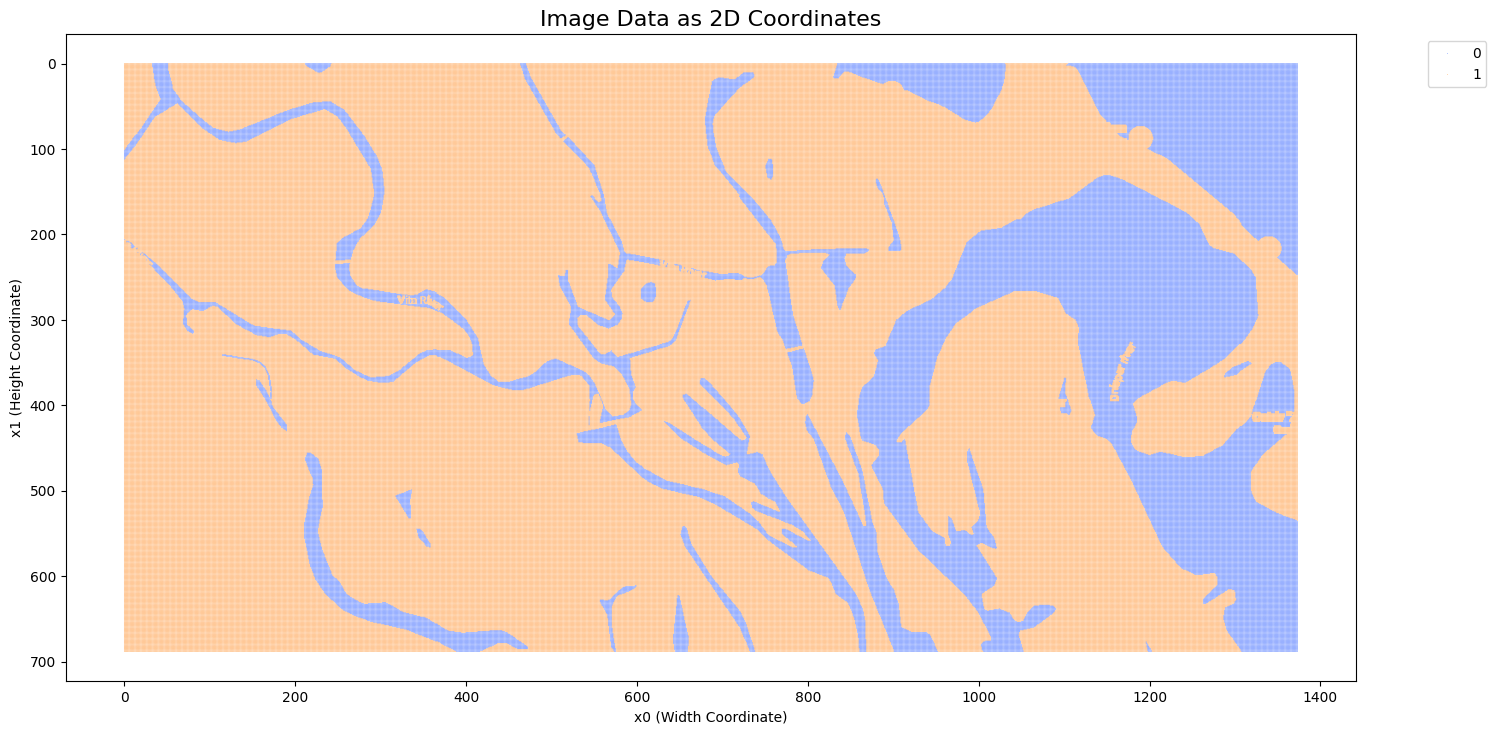

In [12]:
visualize_coordinate_dataframe(df_img)

## 2. Train a flat model

In [ ]:
ann_flat_model = keras.Sequential([
    # Input layer: specify the shape of our features (x0, x1 -> 2 features)
    layers.InputLayer(input_shape=[2]),
    
    # Hidden layer 1: N neurons
    # TODO 1: set any number neurons in this layer
    # TODO 2: try other activation functions
    layers.Dense(100, activation="relu"),
    
    # Output layer: 2 neurons for prediction of 2 classes
    layers.Dense(2, activation="softmax")
])



# Conclusions on work